## Reproduce figures in the paper for  GAS/VVS

In [1]:
base_dir = '../results/'
dir_individual = base_dir + 'gaswvs/'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ast
from collections import defaultdict

import sys
sys.path.append('..')

In [3]:
from plot_utils.models import hf_models, model_names, instruct, model_sizes, openai_models

all_models = list(set(hf_models) - {'mpt', 'mpt-chat', 'mpt-instruct'})
all_models = sorted(all_models, key=lambda x: model_sizes[x])
base_models = sorted(list(set(all_models) - set(instruct.keys())), key=lambda x: model_sizes[x])
instruction_models = list(set(instruct.keys()).intersection(set(all_models)))
instruction_models = sorted(instruction_models, key=lambda x: model_sizes[x])

### Load human responses

In [4]:
nqs = 2520  # total number of questions from which we have responses
dataset = pd.read_csv('../results/global_opinions.csv')['selections'][:nqs]

def convert_dict(string_representation):
    content_start = string_representation.index('{')
    content_end = string_representation.rindex('}') + 1
    content = string_representation[content_start:content_end]

    dict_ast = ast.literal_eval(content)

    return defaultdict(list, dict_ast)

def process_name(name):
    if '(' in name:
         name = name[:name.rfind('(')]
    return name.strip()

# Extract distributions for each question and country
census_responses = {i: {} for i in range(nqs)}
for i, row in enumerate(dataset):
    for c, p in convert_dict(row).items():
        census_responses[i][process_name(c)] = np.array(p)
        
countries = set.union(*[set(cv.keys()) for cv in census_responses.values()])
n_categories = {i: len(list(convert_dict(row).values())[0]) for i, row in enumerate(dataset)}
variables = list(n_categories.keys())

### Load model responses

In [5]:
from surveying_llms.load_responses import load_adjusted_responses
choice_responses, adjusted_responses = load_adjusted_responses(dir_individual, all_models, variables)

variables = [v for v in variables if adjusted_responses[v][all_models[0]].size != 1]
choice_responses = {k: v for k, v in choice_responses.items() if k in variables}
adjusted_responses = {k: v for k, v in adjusted_responses.items() if k in variables}
print('Number of questions: ', len(variables))

Loading adjusted responses...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [01:51<00:00,  4.29s/it]

Number of questions:  2496


In [6]:
from plot_utils.plot_utils import compute_entropy, compute_kl

uniform_responses = {var: np.ones(n_categories[var]) / n_categories[var] for var in variables}
uniform_entropies = {var: compute_entropy(uniform_responses[var]) for var in variables}
adjusted_norm_entropies = {v: {m: compute_entropy(adjusted_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}
adjusted_kl_uniform = {v: {m: compute_kl(adjusted_responses[v][m], uniform_responses[v])
                   for m in all_models} for v in variables}

### Figure 2a

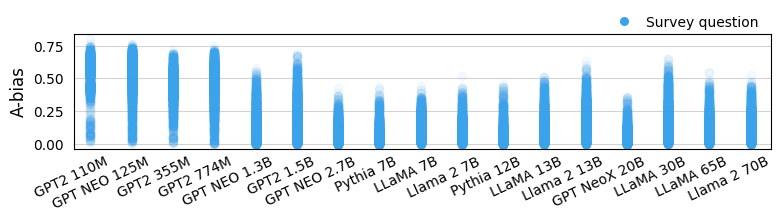

In [7]:
from plot_utils.plot_utils import plot_a_bias, plot_abias_vs_entropy

a_bias = {m: [abs(choice_responses[v][m][0] - (1. / n_categories[v])) for v in variables] for m in base_models}
plot_a_bias(a_bias, base_models, model_names, alpha=0.05)
plt.savefig('../plots/a_bias_gas.pdf', bbox_inches='tight')

### Figure 4  and Figure 5a

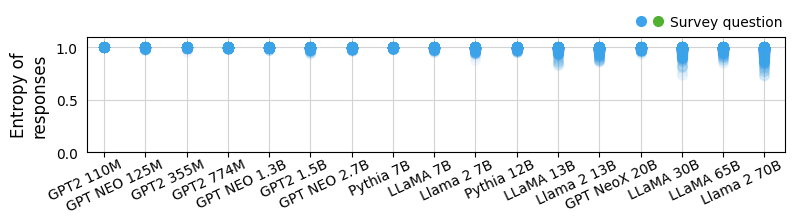

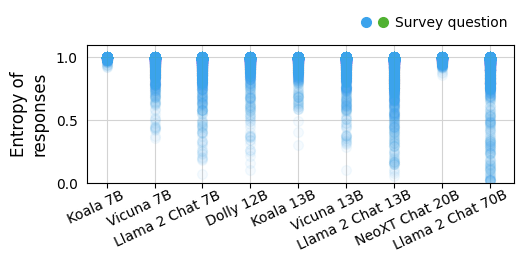

In [8]:
from plot_utils.plot_utils import plot_adjusted_entropy

plot_adjusted_entropy(adjusted_norm_entropies, None, 
                      base_models, variables, model_names, figsize=(9, 1.5), alpha=0.05)
plt.savefig('../plots/adjusted_entropy_gas.pdf', bbox_inches='tight')

plot_adjusted_entropy(adjusted_norm_entropies, None, 
                      instruction_models, variables, model_names, figsize=(5.5, 1.8), alpha=0.05)
plt.savefig('../plots/adjusted_entropy_ft_gas.pdf', bbox_inches='tight')

### Alignment to different subgroups

In [9]:
def compute_jsd(p, q):
    m = (p + q) / 2
    return 1 - 0.5 * (compute_kl(p, m) + compute_kl(q, m))

In [10]:
alignment = {m: {c: np.mean([compute_jsd(adjusted_responses[v][m], census_responses[v][c]) 
                             for v in variables if c in census_responses[v]]) 
                 for c in countries} for m in all_models}
        
alignment_model_uniform = {m: [] for m in all_models}
for v, ms in adjusted_responses.items():
    for m, rm in ms.items():
        u = np.ones(rm.size) / rm.size
        alignment_model_uniform[m].append(compute_jsd(rm, u))
alignment_model_uniform = {m: np.mean(alignment_model_uniform[m]) for m in all_models}

### Figure 6

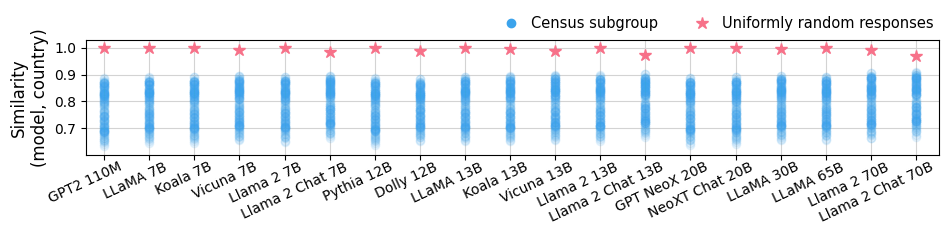

In [11]:
from plot_utils.plot_utils import plot_divergence_subgroups

fewer_models = list(set(all_models) - set(['gptneo125m', 'gpt2m', 'gpt2l', 
                                      'gptneo1.3b', 'gpt2xl', 'gptneo2.7b', 'pythia7']))
fewer_models = sorted(fewer_models, key=lambda x: model_sizes[x])

plot_divergence_subgroups(alignment, alignment_model_uniform, fewer_models, model_names, 
                          ylim=[0.6, 1.03], yticks=[0.7, 0.8, 0.9, 1.],
                          ylabel='Similarity\n(model, country)', clabel='Country')
plt.savefig('../plots/alignment_subgroups_gas.pdf', bbox_inches='tight')

### Figure 9a

#### With all countries in the database

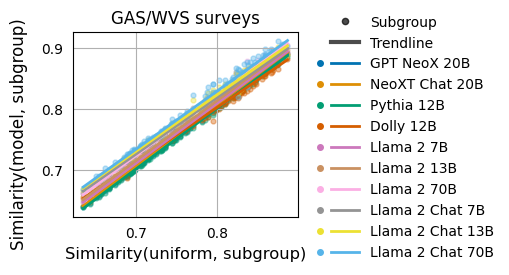

In [12]:
from plot_utils.plot_utils import plot_similarity_opinions

alignment_census_uniform = {c: [] for c in countries}
for v, cs in census_responses.items():
    for c, rc in cs.items():
        u = np.ones(rc.size) / rc.size
        alignment_census_uniform[c].append(compute_jsd(rc, u))
alignment_census_uniform = [np.mean(alignment_census_uniform[c]) for c in countries]


fewer_models = ['gptneox', 'gptneoxchat',
                'pythia12', 'dolly12b',
                'llama2-7b', 'llama2-13b', 'llama2-70b',
                'llama2-7b-chat', 'llama2-13b-chat', 'llama2-70b-chat']

ylabel = 'Similarity(model, subgroup)'
xlabel = 'Similarity(uniform, subgroup)'
title = 'GAS/WVS surveys'

plot_similarity_opinions(countries, alignment, alignment_census_uniform, 
                         fewer_models, model_names,
                         xlabel, ylabel, title)

#### With the countries considered by Durmus et al.  at https://llmglobalvalues.anthropic.com/

In [18]:
countries = {
    'United States',
    'Canada',
    'Mexico',
    'Nicaragua',
    'Venezuela',
    'Colombia',
    'Peru',
    'Brazil',
    'Bolivia',
    'Argentina',
    'Chile',
    'Britain',
    'Spain',
    'France',
    'Italy',
    'Belgium',
    'Netherlands',
    'Denmark',
    'Germany',
    'Sweden',
    'Poland',
    'Lithuania',
    'Hungary',
    'Ukraine',
    'Slovakia',
    'Bulgaria',
    'Greece',
    'Russia',
    'Turkey',
    'Morocco',
    'Tunisia',
    'Egypt',
    'Senegal',
    'Mali',
    'Burkina Faso',
    'Ghana',
    'Nigeria',
    'Angola',
    'Uganda',
    'Kenya',
    'Ethiopia',
    'Israel',
    'Jordan',
    'Uzbekistan',
    'Pakistan',
    'China',
    'Bangladesh',
    'Thailand',
    'Vietnam',
    'Indonesia',
    'Malaysia',
    'Taiwan',
    'Japan',
    'Philippines',
    'Australia'
}

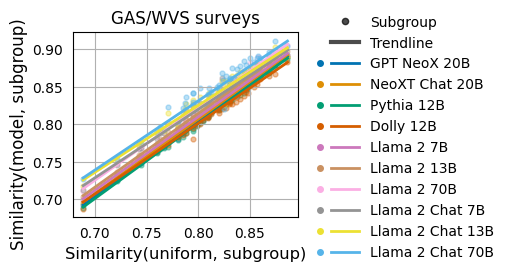

In [19]:
from plot_utils.plot_utils import plot_similarity_opinions

alignment_census_uniform = {c: [] for c in countries}
for v, cs in census_responses.items():
    for c in countries.intersection(set(cs.keys())):
        rc = cs[c]
        u = np.ones(rc.size) / rc.size
        alignment_census_uniform[c].append(compute_jsd(rc, u))
alignment_census_uniform = [np.mean(alignment_census_uniform[c]) for c in countries]


fewer_models = ['gptneox', 'gptneoxchat',
                'pythia12', 'dolly12b',
                'llama2-7b', 'llama2-13b', 'llama2-70b',
                'llama2-7b-chat', 'llama2-13b-chat', 'llama2-70b-chat']

ylabel = 'Similarity(model, subgroup)'
xlabel = 'Similarity(uniform, subgroup)'
title = 'GAS/WVS surveys'

plot_similarity_opinions(countries, alignment, alignment_census_uniform, 
                         fewer_models, model_names,
                         xlabel, ylabel, title)
plt.savefig('../plots/alignment_gaswvs.pdf', bbox_inches='tight')